# Vehicle  & Lane Detection  - From Udacity's  nanodegree

From  https://www.udacity.com/drive , based on:
* https://github.com/udacity/CarND-LaneLines-P1
* https://github.com/udacity/CarND-Advanced-Lane-Lines
* https://github.com/udacity/CarND-Vehicle-Detection


In [52]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import time
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


#### Utility functions for visualization

In [53]:
def plot_compare (image1,image2, str1,str2):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(str1, fontsize=30)
    ax2.imshow(image2)
    ax2.set_title(str2, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return 'Example:'

def plot_compare_to_gray(image1,image2, str1,str2):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(str1, fontsize=30)
    ax2.imshow(image2,cmap='gray')
    ax2.set_title(str2, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return 'Example:'

In [54]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    draw_img = np.copy(img)
    for box in bboxes :
        
        cv2.rectangle(draw_img, box[0],box[1], color, thick)
    
    return draw_img

## Lane lines detection using Canny Edges and Hough

In [202]:
import math

###################################################
gaussian_kernel_size=5 
canny_low_threshold=50  
canny_high_threshold=150 
houge_rho=2 
houge_theta=np.pi/180
houge_threshold=15 
houge_min_line_len=30
houge_max_line_gap=30 
###################################################

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color1=[255,0,0],color2=[0,0,255], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            
             if ((y2-y1)/(x2-x1)) > 0.1  :
                    
                cv2.line(img, (x1, y1), (x2, y2), color1, thickness)
            
             if ((y2-y1)/(x2-x1)) < -0.1  :
            
                cv2.line(img, (x1, y1), (x2, y2), color2, thickness)
            
## draw_lines_better tries to improve lane detection
def draw_lines_better(img, lines, color=[255, 0, 0], thickness=8):
    """
    (A) This function differentiates right lane mark from left lane mark according to slop
    (B) It also applied slope filltering to ignore moderated slopes (under the assumption that highway turns
    cannot be too sharp)
    (C) 
    """
    right_lines=[]
    left_lines=[]
    imshape = img.shape
    right_slope_avg =0.
    right_slope_counter =0
    left_slope_avg =0.
    left_slope_counter =0
    right_y_last =0
    right_x_last =0
    left_y_last =0
    left_x_last =0
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if ((y2-y1)/(x2-x1)) > 0.6  :
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                right_slope_avg =  ((right_slope_avg*right_slope_counter)+((y2-y1)/(x2-x1)))/(right_slope_counter+1)
                right_lines.append([x1,y1,x2,y2])
                right_slope_counter+=1
                right_x_last = x2  ## keeping last *relevant* point 
                right_y_last = y2  ## keeping last *relevant* point
                
                
                
            if ((y2-y1)/(x2-x1)) < -0.6  :
                #cv2.line(img, (x1, y1), (x2, y2), [0,0,255], thickness)     
                left_slope_avg =  ((left_slope_avg*left_slope_counter)+((y2-y1)/(x2-x1)))/(left_slope_counter+1)
                left_lines.append([x1,y1,x2,y2])
                left_slope_counter+=1
                left_x_last = x2
                left_y_last = y2
               

    ## calculating the end points of lines with the avarage slops - 
    ## For reference -
    ## vertices = np.array([[(0,imshape[0]),(imshape[1]/2, imshape[0]/1.75), (imshape[1],imshape[0])]], dtype=np.int32)
    if right_slope_avg :
        
        b_right = right_y_last - right_slope_avg*right_x_last
        right_top_y = imshape[0]/1.65
        right_top_x = (right_top_y - b_right)/right_slope_avg
        right_top_y = math.floor(right_top_y)
        right_top_x = math.floor(right_top_x)
        right_buttom_y =  imshape[0]
        right_buttom_x = (right_buttom_y - b_right)/right_slope_avg
        right_buttom_x = math.floor (right_buttom_x)
        #right_endpoint_top =[right_top_x,right_top_y,right_lines[0][0], right_lines[0][1]]
        #right_lines = [right_endpoint_top] + right_lines
        #right_endpoint_buttom = [right_lines[-1][2],right_lines[-1][3],right_buttom_x,right_buttom_y]               
        #right_lines = right_lines + [right_endpoint_buttom]
        cv2.line(img, (right_top_x, right_top_y), (right_buttom_x,right_buttom_y), [255,0,0], thickness)
        
        
    if left_slope_avg :
        
        b_left = left_y_last - left_slope_avg*left_x_last
        left_top_y = imshape[0]/1.65
        left_top_x = (left_top_y - b_left)/left_slope_avg
        left_top_y = math.floor(left_top_y)
        left_top_x = math.floor(left_top_x)
        left_buttom_y =  imshape[0]
        left_buttom_x = (left_buttom_y - b_left)/left_slope_avg
        left_buttom_x = math.floor (left_buttom_x)
        #left_endpoint_top =[left_top_x,left_top_y,left_lines[0][0], left_lines[0][1]]
        #left_lines = [left_endpoint_top] + left_lines
        #left_endpoint_buttom = [left_lines[-1][2],left_lines[-1][3],left_buttom_x,left_buttom_y]               
        #left_lines = left_lines + [left_endpoint_buttom]
        cv2.line(img, (left_top_x, left_top_y), (left_buttom_x,left_buttom_y), [0,0,255], thickness)

##    if (right_slope_avg*left_slope_avg) :
##        vertices = np.array([[(left_buttom_x,left_buttom_y),(left_top_x, left_top_y),(right_top_x, right_top_y),(right_buttom_x,right_buttom_y)]], dtype=np.int32)              
##        #cv2.fillPoly(img, vertices, (0,255,0))

        
            
## hough_lines_better calles  draw_lines_better befor returning the image          
def hough_lines_better(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    (A) Same function as hough_lines(..) but using draw_lines_better(..) 
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_better(line_img, lines)
    return line_img
            
            
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines,color1=[255,0,0],color2=[0,0,255])
    return line_img

# Python 3 has support for cool math symbols.



In [56]:
def process_canny_lines(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    ##############Process pipileline##############
    img=(image*255).astype('uint8') #Step#1 - convertion to grayscale
    gray_img=grayscale(image)
    blur_img=gaussian_blur(gray_img, gaussian_kernel_size) #Step#2 - Gaussian Blur
    edge_img= canny(blur_img, canny_low_threshold, canny_high_threshold) #Step#3 - Canny edge detection
    imshape = image.shape
    #vertices = np.array([[(0,imshape[0]),(imshape[1]/2, imshape[0]/1.75), (imshape[1],imshape[0])]], dtype=np.int32) #Step#4 - Applying polygone filter on area of interest
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2-30, 450),(imshape[1]/2+30, 450), (imshape[1],imshape[0])]], dtype=np.int32) #Step#4 - Applying polygone filter on area of interest
    masked_img=region_of_interest(edge_img, vertices) #Step#5 - Applying Houge transform to find lines within area of interest
    # reverted from hough_lines_better() for the fusion project
    line_img=hough_lines(masked_img, houge_rho, houge_theta, houge_threshold, houge_min_line_len, houge_max_line_gap)
    
    ##############Improvments##############
    
    
    
    
    
    
    
    ### Image overlay and return
   
    return line_img

### More Advanced Lane detection technic

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

#### Measuring camera's distortion for calibration

In [123]:
nx = 9
ny = 6

objpoints=[]  # Arrays to store object points and image points from all the images.
imgpoints=[]
objp = np.zeros((nx*ny,3), np.float32)  # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


images = glob.glob('../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')  # Make a list of calibration images
for fname in images:  # Step through the list and search for chessboard corners
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None) # Find the chessboard corners
    if ret == True: # If found, add object points, image points
        objpoints.append(objp)
        imgpoints.append(corners)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [124]:
# Bird's eye transform, for top lane view

source_points = np.float32([(200,720),(552,480),(740,480),(1100,720)])  # Manualy measured on the refrence image "straight_lines1.jpg"
destination_points = np.float32([(200,720),(200,0),(1100,0),(1100,720)])# Desired transformation taking the X values of meeting point of car hood and lane lines as reference 
M = cv2.getPerspectiveTransform(source_points, destination_points)    #Compute the perspective transform
Minv = cv2.getPerspectiveTransform(destination_points, source_points) #Compute the inverse perspective transform

# Spatial(Sobel) detection functions
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x' :
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient=='y' :
         sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
   
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    scaled_sobel = np.arctan2(sobely, sobelx) 
    dir_binary = np.zeros_like(scaled_sobel)
    dir_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return dir_binary

# Color space transforms

def hls_s_threshold(img, s_thresh=(0,255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    return  binary

def hls_l_threshold(img, l_thresh=(0,255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1
    
    return  binary

def hsv_s_threshold(img, s_thresh=(0,255)):

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    return  binary

def gray_threshold(img, thresh=(180, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
      
    return  binary



In [59]:
# Lane's related data stracture class - for  moving information across video frames

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  #OK
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  #OK
        #radius of curvature of the line in some units
        self.radius_of_curvature = None #OK
        #distance in meters of vehicle center from the line
        self.line_base_pos = None  
        #distance in meters of vehicle center from the line
        self.center_gap = None  #OK
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #y values for plotting
        self.ploty= [] #OK
        #x values for plotting
        self.fitx= [] #OK
        #Saving last inconstitanct reason
        self.fail_reason= []
        #Keeping  count of inconsistancies
        self.fail_count= 0
        #Keeping  count of inconsistancies
        self.very_first= True
        

In [62]:
# Lane detection - 

def find_curve_radius (lefty,leftx,righty,rightx):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    y_eval = 550
    left_curverad1 = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad1 = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    y_eval = 540
    left_curverad2 = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad2 = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    y_eval = 530
    left_curverad3 = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad3 = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    left_curverad = (left_curverad1+left_curverad2+left_curverad3)/3
    right_curverad = (right_curverad1+right_curverad2+right_curverad3)/3
    return  left_curverad, right_curverad

def find_initial_lanes (binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) # Take a histogram of the bottom half of the image
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]//2)  # Find the peak of the left and right halves of the histogram
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9 # Choose the number of sliding windows
    window_height = np.int(binary_warped.shape[0]//nwindows) # Set height of windows
    nonzero = binary_warped.nonzero()  # Identify the x and y positions of all nonzero pixels in the image
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base # Identify the x and y positions of all nonzero pixels in the image
    rightx_current = rightx_base
    margin = 50 # Set the width of the windows +/- margin
    minpix = 100 # Set minimum number of pixels found to recenter window
    left_lane_inds = [] # Create empty lists to receive left and right lane pixel indices
    right_lane_inds = []

    for window in range(nwindows): # Step through the windows one by one
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Dealing with empty pixles array (this allows for better Binaries tunning)
    # Fit a second order polynomial to each
    if (len(lefty) == 0):
        left_fit = Left_line.best_fit
    else :
        left_fit = np.polyfit(lefty, leftx, 2)
        
    if (len(righty) == 0):
        right_fit = Right_line.best_fit
    else :
        right_fit = np.polyfit(righty, rightx, 2)   
        
   
    
    if ((len(lefty) == 0) | (len(righty) == 0)):
        
        left_curverad = Left_line.radius_of_curvature
        right_curverad =  Right_line.radius_of_curvature
    else:
    # Find curve radius (in meters)
        left_curverad, right_curverad = find_curve_radius (lefty,leftx,righty,rightx)
    
    # calculate lane's  center position (first calculating in pixles, then converting to meters)
    y_eval = 680 #bottom, but not over hood
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_lane_position  = left_fit[0]*y_eval**2 + left_fit[1]*y_eval +left_fit[2]
    right_lane_position  = right_fit[0]*y_eval**2 + right_fit[1]*y_eval +right_fit[2]
    lane_center = left_lane_position + (right_lane_position  - left_lane_position)/2
    gap_from_center = ((1280//2) - lane_center)* xm_per_pix
    
    ########## Updating Line Objects ################ (None conditional)
    Right_line.diffs = 0
    Left_line.diffs = 0
    Right_line.fail_count=0
    Left_line.fail_count=0
    Right_line.fail_reason = 'None'
    Left_line.fail_reason = 'None'

    smooth_factor = 3

    if (Right_line.very_first == True):
        # Right Line
        Right_line.very_first = False
        Right_line.detected = True
        Right_line.current_fit  = right_fit
        Right_line.best_fit = right_fit
        Right_line.radius_of_curvature = right_curverad    
        Right_line.center_gap = gap_from_center
        Right_line.line_base_pos = right_lane_position
   
        # Generate x and y values for plotting
        Right_line.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        Right_line.fitx = right_fit[0]*Right_line.ploty**2 + right_fit[1]*Right_line.ploty + right_fit[2]

        # Left Line
        Left_line.detected = True
        Left_line.current_fit = left_fit
        Left_line.best_fit = left_fit
        Left_line.radius_of_curvature = left_curverad
        Left_line.line_base_pos = left_lane_position
        # Generate x and y values for plotting
        Left_line.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        Left_line.fitx = left_fit[0]*Left_line.ploty**2 + left_fit[1]*Left_line.ploty + left_fit[2]
    else:
        Right_line.detected = True
        Right_line.diffs += (Right_line.current_fit - right_fit)
        Right_line.current_fit = right_fit
        Right_line.best_fit = (Right_line.best_fit*(smooth_factor-1) + right_fit )/smooth_factor  # Best fit averaging 
        Right_line.radius_of_curvature = (Right_line.radius_of_curvature*(smooth_factor-1) + right_curverad)/smooth_factor
        Right_line.center_gap = (Right_line.center_gap*(smooth_factor-1) + gap_from_center)/smooth_factor
        Right_line.line_base_pos = right_lane_position
        # Generate x and y values for plotting
        Right_line.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        Right_line.fitx = Right_line.best_fit[0]*Right_line.ploty**2 +Right_line.best_fit[1]*Right_line.ploty + Right_line.best_fit[2]

    # Left Line
        Left_line.detected = True
        Left_line.diffs += (Left_line.current_fit - left_fit)
        Left_line.current_fit = left_fit
        Left_line.best_fit = (Left_line.best_fit*(smooth_factor-1) + left_fit )/smooth_factor  # Best fit averaging 
        Left_line.radius_of_curvature = (Left_line.radius_of_curvature*(smooth_factor-1) + left_curverad)/smooth_factor
        Left_line.line_base_pos = left_lane_position
        # Generate x and y values for plotting
        Left_line.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        Left_line.fitx = Left_line.best_fit[0]*Left_line.ploty**2 + Left_line.best_fit[1]*Left_line.ploty + Left_line.best_fit[2]

        
        
    return None 

def find_consecutive_lanes (binary_warped):

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])  
    margin = 100
    left_lane_inds = ((nonzerox > (Left_line.current_fit[0]*(nonzeroy**2) + Left_line.current_fit[1]*nonzeroy + Left_line.current_fit[2] - margin)) & (nonzerox < (Left_line.current_fit[0]*(nonzeroy**2) + Left_line.current_fit[1]*nonzeroy + Left_line.current_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (Right_line.current_fit[0]*(nonzeroy**2) + Right_line.current_fit[1]*nonzeroy + Right_line.current_fit[2] - margin)) & (nonzerox < (Right_line.current_fit[0]*(nonzeroy**2) + Right_line.current_fit[1]*nonzeroy + Right_line.current_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Dealing with empty pixles array (this allows for better Binaries tunning)
    # Fit a second order polynomial to each
    if (len(lefty) == 0):
        left_fit = Left_line.best_fit
    else :
        left_fit = np.polyfit(lefty, leftx, 2)

    if (len(righty) == 0):
        right_fit = Right_line.best_fit
    else :
        right_fit = np.polyfit(righty, rightx, 2)   



    if ((len(lefty) == 0) | (len(righty) == 0)):

        left_curverad = Left_line.radius_of_curvature
        right_curverad =  Right_line.radius_of_curvature
    else:
    # Find curve radius (in meters)
        left_curverad, right_curverad = find_curve_radius (lefty,leftx,righty,rightx)

    # calculate lane's  center position (first calculating in pixles, then converting to meters)
    y_eval = 680 #bottom, but not over hood
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_lane_position  = left_fit[0]*y_eval**2 + left_fit[1]*y_eval +left_fit[2]
    right_lane_position  = right_fit[0]*y_eval**2 + right_fit[1]*y_eval +right_fit[2]
    lane_center = left_lane_position + (right_lane_position  - left_lane_position)/2
    gap_from_center = ((1280//2) - lane_center)* xm_per_pix

    ########## outlier rejection  ################ 

    #Checking that lane space didn't change too fast
    left_polynom  = np.poly1d(left_fit).integ()
    right_polynom  = np.poly1d(right_fit).integ()
    lane_area = (right_polynom(720)-right_polynom(0)) - (left_polynom(720)-left_polynom(0))

    last_left_polynom  = np.poly1d(Left_line.best_fit).integ()
    last_right_polynom  = np.poly1d(Right_line.best_fit).integ()
    last_lane_area = (last_right_polynom(720)-last_right_polynom(0)) - (last_left_polynom(720)-last_left_polynom(0))

    area_ratio = last_lane_area/lane_area

    if (np.abs(left_curverad - right_curverad) > 1500) :         
        Right_line.fail_count = Right_line.fail_count + 1 
        Right_line.fail_reason = 'Right/Left curvature difference'
    #Checking that they are separated by approximately the right distance horizontally (in pixles)
    elif (np.abs(Right_line.line_base_pos - Left_line.line_base_pos -(right_lane_position-left_lane_position)) > 80):
        Right_line.fail_count = Right_line.fail_count + 1
        Right_line.fail_reason = 'Lane width'
    #Checking for rapid change in curvature
    elif (np.abs(Right_line.radius_of_curvature - right_curverad) > 1400):
        Right_line.fail_count = Right_line.fail_count + 1
        Right_line.fail_reason = 'Right curvature'
    #Checking for rapid change in curvature
    elif (np.abs(Left_line.radius_of_curvature - left_curverad) > 1400):
        Right_line.fail_count = Right_line.fail_count + 1
        Right_line.fail_reason = 'Left curvature'
    # Checking for rapid change in car's location
    elif (np.abs(Right_line.center_gap - gap_from_center )  > 0.2):       
        Right_line.fail_count = Right_line.fail_count + 1
        Right_line.fail_reason = 'Car location in lane'

    smooth_factor = 3


    if ((Right_line.fail_count >4) | (area_ratio >2) | (area_ratio<0.5) ):

        Right_line.detected = False    
    else:
    ####### End of outlier rejection  ############# 

     # Right Line

        Right_line.diffs += (Right_line.current_fit - right_fit)
        Right_line.current_fit = right_fit
        Right_line.best_fit = (Right_line.best_fit*(smooth_factor-1) + right_fit )/smooth_factor  # Best fit averaging 
        Right_line.radius_of_curvature = (Right_line.radius_of_curvature*(smooth_factor-1) + right_curverad)/smooth_factor
        Right_line.center_gap = (Right_line.center_gap*(smooth_factor-1) + gap_from_center)/smooth_factor
        Right_line.line_base_pos = right_lane_position
        # Generate x and y values for plotting
        Right_line.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        Right_line.fitx = Right_line.best_fit[0]*Right_line.ploty**2 +Right_line.best_fit[1]*Right_line.ploty + Right_line.best_fit[2]

    # Left Line

        Left_line.diffs += (Left_line.current_fit - left_fit)
        Left_line.current_fit = left_fit
        Left_line.best_fit = (Left_line.best_fit*(smooth_factor-1) + left_fit )/smooth_factor  # Best fit averaging 
        Left_line.radius_of_curvature = (Left_line.radius_of_curvature*(smooth_factor-1) + left_curverad)/smooth_factor
        Left_line.line_base_pos = left_lane_position
        # Generate x and y values for plotting
        Left_line.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        Left_line.fitx = Left_line.best_fit[0]*Left_line.ploty**2 + Left_line.best_fit[1]*Left_line.ploty + Left_line.best_fit[2]

    return None



In [139]:


def advanced_lane_finding_image_pipeline(undist_image,mtx,dist,M,Minv,fill_color=(0,255, 0)):
    
    #Camera calibration (only once, outside of pipeline)
    #Distortion correction (moved to main image pipeline function)
    #undist_image = cv2.undistort(image, mtx, dist, None, mtx)
    #Color thresholds
    s_hls_binary = hls_s_threshold(undist_image, s_thresh=(150, 255)) # Started with 170
    s_hsv_binary = hsv_s_threshold(undist_image, s_thresh=(150, 255)) # Started with 170
    #Gradiet thresholds
    grad_x = abs_sobel_thresh(undist_image, orient='x', sobel_kernel=3, thresh=(20, 100))
    grad_y = abs_sobel_thresh(undist_image, orient='y', sobel_kernel=3, thresh=(20, 100))
    grad_mag = mag_thresh(undist_image, sobel_kernel=9, mag_thresh=(30, 80))
    grad_dir = dir_threshold(undist_image, sobel_kernel=15, thresh=(0.7, 1.3))
    gray_binary = gray_threshold(undist_image,(165, 255))  # Started with 180
    # Gradiet Binaries combination
    grad_binary = np.zeros_like(grad_x)
    grad_binary[((grad_x == 1) & (grad_y == 1)) | ((grad_mag == 1) & (grad_dir == 1))] = 1
    # Final binaries combination
    combined_binary = np.zeros_like(grad_x)
    #combined_binary[((s_hsv_binary == 1) | (s_hls_binary == 1)) | ((grad_x == 1) & (grad_y == 1)) ] = 1
    combined_binary[(((s_hsv_binary == 1)) | ((grad_x == 1) & (grad_y == 1)))&(gray_binary == 1) ] = 1

    #Perspective  transform (warping)
    warped_image = cv2.warpPerspective(combined_binary, M, (1280,720), flags=cv2.INTER_LINEAR)
    #Curvature
   
    if ((Right_line.detected==False) | (Left_line.detected==False)): # the Right_line.detected is used as flag to trigger 
                                                                     # reevaluation of lines location, throughout the movie
        find_initial_lanes(warped_image)  # detecting lines from scratch
        
    else: 
    
        find_consecutive_lanes(warped_image) # detecting lines using existing polynoms
        
    
    avg_curvrad = (Left_line.radius_of_curvature + Right_line.radius_of_curvature)/2
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([Left_line.fitx, Left_line.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([Right_line.fitx, Right_line.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), fill_color)
    #cv2.polylines(color_warp,np.int_([pts_left]),False,(0,0,255))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_image.shape[1], undist_image.shape[0])) 
    # Combine the result with the original image
    blank_img = np.zeros((undist_image.shape[0], undist_image.shape[1], 3), dtype=np.uint8)
    output_image = cv2.addWeighted(blank_img, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(output_image,'Curvature radius : %.2f[m]'% avg_curvrad ,(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    if (Right_line.center_gap<0) :
        cv2.putText(output_image,'Car is %.2f[m] left of lane center'% (-Right_line.center_gap),(50,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    else:
        cv2.putText(output_image,'Car is %.2f[m] right of lane center'% (Right_line.center_gap),(50,100), font, 1,(255,255,255),2,cv2.LINE_AA)
  # debug prints
  #  if ((Right_line.detected==False) | (Left_line.detected==False)):
  #      
  #      cv2.putText(output_image,'   Outliere detected',(50,260), font, 2,(255,0,0),2,cv2.LINE_AA)
  #  else :
  #      
  #      cv2.putText(output_image,'No Outliere detected',(50,260), font, 2,(0,255,0),2,cv2.LINE_AA)
    
    
    return  output_image
    

In [140]:
Right_line = Line()
Left_line = Line()

#### Lane finding on still image (example)4

'Example:'

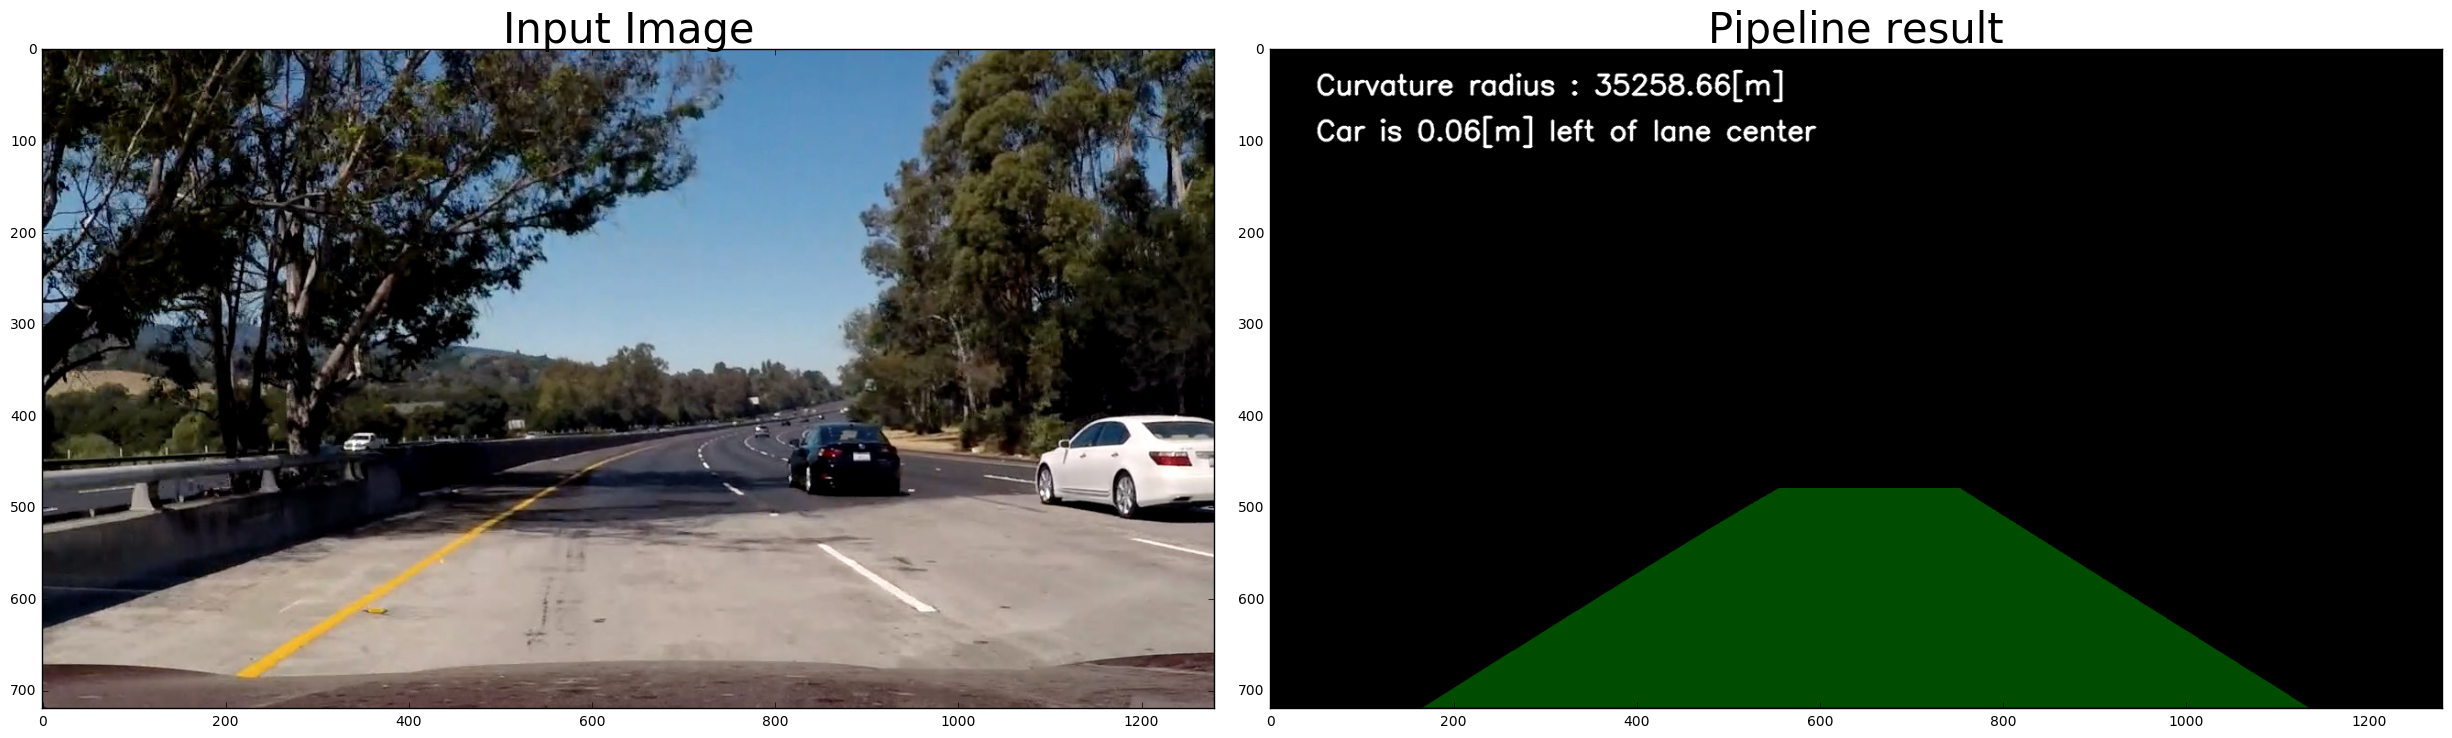

In [193]:
image = mpimg.imread('test_images/test5.jpg')
Right_line.detected= Left_line.detected = False
Right_line.very_first = True
output_image = advanced_lane_finding_image_pipeline(image,mtx,dist,M,Minv)
plot_compare(image,output_image,'Input Image','Pipeline result')

# Vehicle tracking

* Performing color space transform,histograms of color, and HOG (Histogram of Oriented Gradients)feature extraction, shape and scale to an input vector on a labeled training set of images and train a classifier Linear SVM classifier
* Sliding-window search on the  trained classifier to search for vehicles in images.
* On the video file - creating a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimating a bounding box for vehicles detected.

## Color Spaces and HOG Features

##### scikit-image
http://scikit-image.org/
* hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L1', visualise=False, transform_sqrt=False, feature_vector=True, normalise=None) - http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog


##### Data normalization 
Using sklearn.StandardScaler()
* StandardScaler() - http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [66]:

def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial2(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist2(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [67]:
def bin_spatial2(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist2(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

###  get_hog_features() & extract_hog_features()

In [68]:
def get_hog_features(image, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), feature_vector=feature_vec)

        return features



def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

## Loading Database (Udacity's CARND)
https://www.udacity.com/drive
* Vehcles - https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
* Non-vehicles - https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip

In [69]:
      
notcars = glob.glob('Training_set/non-vehicles/*/*.png')
cars = glob.glob('Training_set/vehicles/*/*.png')

      
        
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = (img.shape[0], img.shape[1], img.shape[2])
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])


Your function returned a count of 8792  cars and 8967  non-cars
of size:  (64, 64, 3)  and data type: float32


### slide_window() 
Returns all possible windows as defined by input variables

In [70]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# General Feature extraction 

In [71]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial2(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist2(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial2(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist2(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())


## search_windows() - execution of classification

In [72]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Learn  features definition and model Training

In [230]:
################# Data Variables  & Model parameters############

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12tra  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 8 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()

################# Training Features Extraction ############
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to Xtra
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.05, random_state=rand_state)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to Extract dataset features and StandardScaler...')

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

################# VSM model instance and training ############

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()




317.14 Seconds to Extract dataset features and StandardScaler...
Using: 12 orientations 8 pixels per cell and 8 cells per block
Feature vector length: 3168
29.92 Seconds to train SVC...
Test Accuracy of SVC =  0.991


# Search windows definitions

In [225]:
image =  mpimg.imread('hi_res_image.jpg')

x=image.shape[1]
y=image.shape[0]


############ Windows definitions ###############
verybig_xy_window = (256,128)
verybig_search_x_start_stop =  [780,1280]
verybig_search_y_start_stop =  [400,690]
verybig_search_overlap = (0.6,0.6)
big_xy_window = (128,128)
big_search_x_start_stop =  [400,1280]
big_search_y_start_stop =  [300,690]
big_search_overlap = (0.6,0.6)
small_xy_window = (32,32)
small_search_x_start_stop =  [600,900]
small_search_y_start_stop =  [420,460]
small_search_overlap = (0.6,0.6)
mid1_xy_window = (96,64)
mid1_search_x_start_stop =  [660,1040]
mid1_search_y_start_stop =  [400,480]
mid1_search_overlap = (0.9,0.9)
mid2_xy_window = (96,96)
mid2_search_x_start_stop =  [660,1280]
mid2_search_y_start_stop =  [400,600]
mid2_search_overlap = (0.7,0.7)

############ Windows generation ###############
verybig_windows = slide_window(image, x_start_stop=verybig_search_x_start_stop, y_start_stop=verybig_search_y_start_stop, 
                    xy_window=verybig_xy_window, xy_overlap=verybig_search_overlap)

big_windows = slide_window(image, x_start_stop=big_search_x_start_stop, y_start_stop=big_search_y_start_stop, 
                    xy_window=big_xy_window, xy_overlap=big_search_overlap)

small_windows = slide_window(image, x_start_stop=small_search_x_start_stop, y_start_stop=small_search_y_start_stop, 
                    xy_window=small_xy_window, xy_overlap=small_search_overlap)

mid1_windows = slide_window(image, x_start_stop=mid1_search_x_start_stop, y_start_stop=mid1_search_y_start_stop, 
                    xy_window=mid1_xy_window, xy_overlap=mid1_search_overlap)

mid2_windows = slide_window(image, x_start_stop=mid2_search_x_start_stop, y_start_stop=mid2_search_y_start_stop, 
                    xy_window=mid2_xy_window, xy_overlap=mid2_search_overlap)

search_window_boxes=[((big_search_x_start_stop[0],big_search_y_start_stop[0]),(big_search_x_start_stop[1],big_search_y_start_stop[1])),
                    ((small_search_x_start_stop[0],small_search_y_start_stop[0]),(small_search_x_start_stop[1],small_search_y_start_stop[1])),
                    ((mid1_search_x_start_stop[0],mid1_search_y_start_stop[0]),(mid1_search_x_start_stop[1],mid1_search_y_start_stop[1])),
                    ((mid2_search_x_start_stop[0],mid2_search_y_start_stop[0]),(mid2_search_x_start_stop[1],mid2_search_y_start_stop[1])),
                    ((verybig_search_x_start_stop[0],verybig_search_y_start_stop[0]),(verybig_search_x_start_stop[1],verybig_search_y_start_stop[1]))]

############ Various Visualizations ###############
# removed verybig_windows +
all_windows =  big_windows + small_windows + mid1_windows + mid2_windows
my_spacial_windows  = all_windows
#window_img = draw_boxes(image, big_windows, color=(0, 0, 255), thick=6)                    
window_img1 = draw_boxes(image, [search_window_boxes[0]], color=(127, 0, 127), thick=2) 
window_img2 = draw_boxes(window_img1, [search_window_boxes[1]],color=(255, 127, 127) , thick=2)                    
window_img3 = draw_boxes(window_img2, [search_window_boxes[2]], color=(0, 0, 255), thick=2)                    
window_img4 = draw_boxes(window_img3, [search_window_boxes[3]], color=(0, 255, 0), thick=2) 
window_img5 = draw_boxes(window_img4, [search_window_boxes[4]], color=(255, 0, 0), thick=2) 

#window_img1 = draw_boxes(image, big_windows, color=(255, 0, 127), thick=6) 
#window_img2 = draw_boxes(window_img1, small_windows, color=(0, 0, 255), thick=6)                    
#window_img3 = draw_boxes(window_img2, mid1_windows, color=(0, 255, 0), thick=6)                    
#window_img4 = draw_boxes(window_img3, mid2_windows, color=(255, 0, 0), thick=6)



### (Non operational code) for testing the pipeline

In [231]:
image = mpimg.imread('test_images/test1.jpg')
#image = mpimg.imread('hi_res_image.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255


# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

################# Search windows definition ############

windows = slide_window(image, x_start_stop=[0,1280], y_start_stop=[390,670],#y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

################# <<< Classification >>> ############

hot_windows = search_windows(image, my_spacial_windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=1)                    
#plt.axis('off')
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.subplots(1, 1, figsize=(10,10))
#plt.imshow(window_img)

### Heat Map Utility functions
* label() - https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html

In [232]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
car_colors=[(0,51,102),(0,128,256),(0,102,0),(255,0,127)]
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(0,labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.rectangle(img, bbox[0], (bbox[0][0]+80,bbox[0][1]-25), car_colors[car_number], -6)
        cv2.putText(img,'car#:%d '% car_number ,(bbox[0][0],bbox[0][1]-10), font, .6,(255,255,255),1,cv2.LINE_AA)
        cv2.rectangle(img, bbox[0], bbox[1], car_colors[car_number], 2)
        cv2.putText(img,'Moving objects detected: %d'% labels[1],(50,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    # Return the image
    return img



#### Heat Map Low-Pass Filter

In [77]:
def filter_bboxes(labels,heatmap):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        #
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        box_width = bbox[1][0] - bbox[0][0]
        box_hieght = bbox[1][1] - bbox[0][1]
        if (( box_width<45) | (box_hieght<20) ):  # filtering out unrealistic boxes
            # Draw the box on the image    
            cv2.rectangle(heatmap, bbox[0], bbox[1], 0, -2) # blank out the heatmap
    # Return the image
    return heatmap

#### Not Operational Heat Map test

In [236]:
heatmap_thrsh=6
heatmap=np.zeros([720,1280])
image = mpimg.imread('test_images/test1.jpg')
heatmap = add_heat(heatmap, hot_windows)
init_heat=heatmap
color_binary = np.dstack(( heatmap, np.zeros_like(heatmap), np.zeros_like(heatmap)))
#heat_img=cv2.addWeighted(image, 1, color_binary,0.2, 0)########
heatmap = apply_threshold(heatmap, heatmap_thrsh)
labels = label(heatmap)
heatmap = filter_bboxes(labels,heatmap)
labels = label(heatmap)
print(labels[1], 'cars found')
#plt.imshow(color_binary, cmap='gray')
# Read in the last image above

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
#plt.axis('off')



2 cars found


In [237]:
# Credit for this visualization code goes to a fellow CarND student - 
#taken from GitHub  shobhitg/CarND-Vehicle-Detection 

def hybrid_image(init_heat, filtered_heat, image ):
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    full_heatmap = np.clip(filtered_heat, 0, 255)
    heatmap = np.clip(init_heat, 0, 255)
    norm = plt.Normalize(vmin=filtered_heat.min(), vmax=filtered_heat.max())
    norm_heatmap = norm(full_heatmap)
    heatmap_image = (np.dstack((norm_heatmap*255, norm_heatmap, norm_heatmap))).astype(np.uint8)
    heatmap_image = cv2.addWeighted(heatmap_image, 1, image, 1, 0)
    
    return heatmap_image
    

NameError: name 'heatmap_image' is not defined

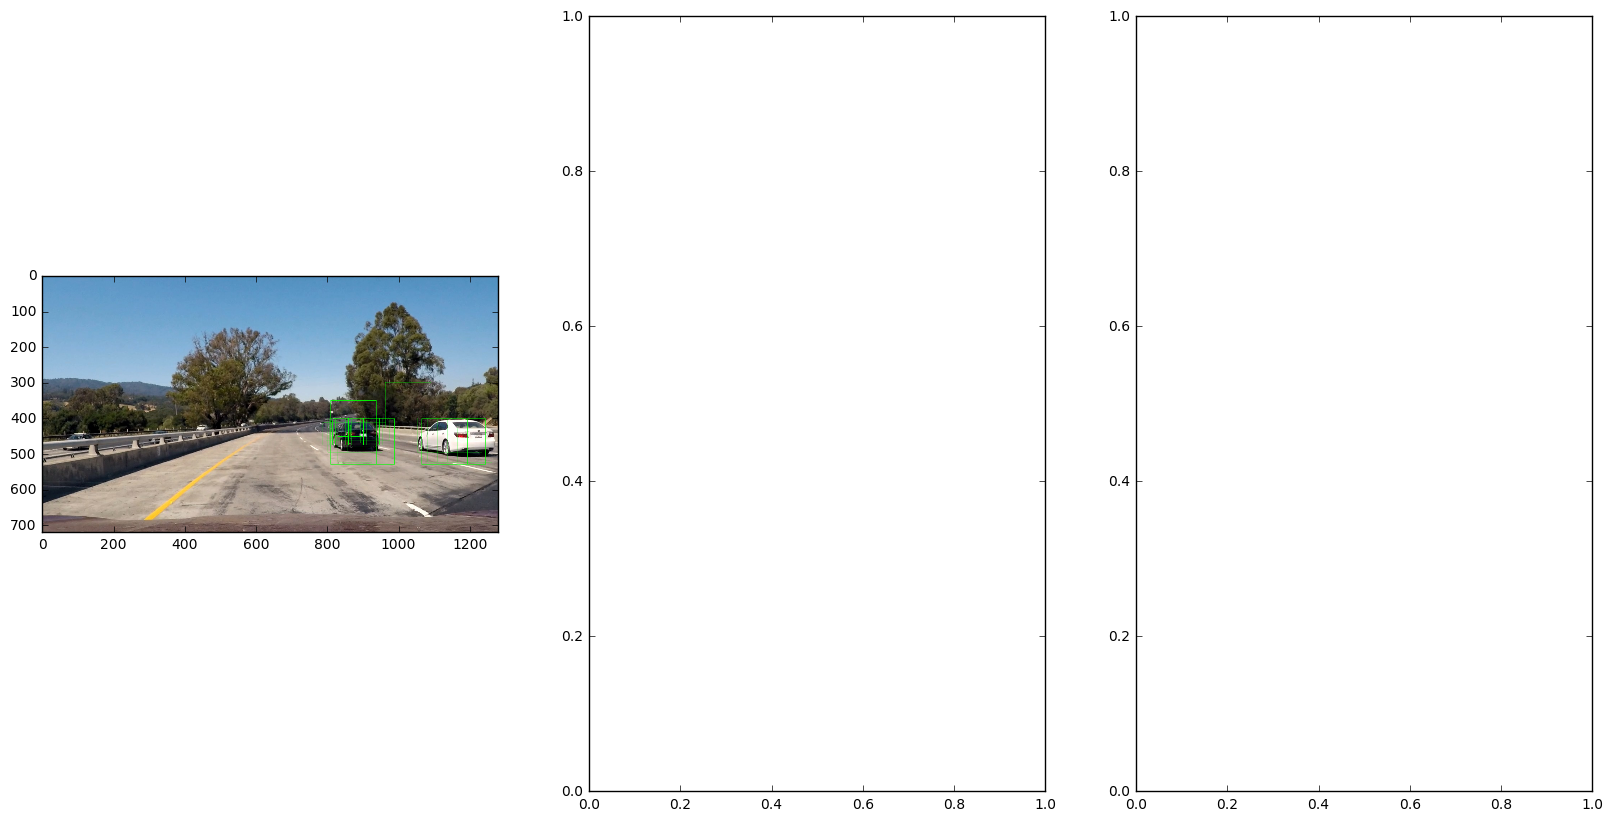

In [238]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(window_img)
ax2.imshow(heatmap_image)
ax3.imshow(draw_img)

## Full Image Pipeline
(Using the above functions)

#### Global Heatmap  class for interframe smoothing

In [ ]:
class Global_heatmap():
    def __init__(self):
        
        self.map = np.zeros([720,1280])
        self.debug_flag=False
        self.t0_flag=True 
        


In [ ]:
global_heatmap = Global_heatmap()

In [222]:
def image_pipeline(image):
   
    image=cv2.undistort(image, mtx, dist, None, mtx)
    img_copy=np.copy(image)
    
    image = image.astype(np.float32)/255
    
    hot_windows = search_windows(image, my_spacial_windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
   
    heatmap_threshold=3                # Threashold corelates to overlap in search windows (# of hit windows on real car)
    heatmap = add_heat(np.zeros([720,1280]), hot_windows)
    init_heat = heatmap                                # initial labeling since the low pass filter uses them to inspect boxes
    labels = label(heatmap)                                       # low pass filter on too small boxes
    heatmap = filter_bboxes(labels,heatmap)
    if (global_heatmap.t0_flag==True ) :
        global_heatmap.map = heatmap                              # If no history exist, for still images and initial frame
        global_heatmap.t0_flag=False 
    else:
        global_heatmap.map =  (global_heatmap.map*2 + heatmap*3)/5  # smoothing visual boxes by adding historical data 
                                                                  # (new data is more important)
    heatmap = apply_threshold(global_heatmap.map, heatmap_threshold)
    labels = label(global_heatmap.map)                  # initial labeling since the low pass filter uses them to inspect boxes
    global_heatmap.map = filter_bboxes(labels,global_heatmap.map)  # low pass filter on too small boxes
    labels = label(global_heatmap.map)                             # Labeling the final data
    draw_img = draw_labeled_bboxes(img_copy, labels)               # Drawing boxes on image
    
    if (global_heatmap.debug_flag == True):                        # debug=True added heatmap to output
        
        draw_img =hybrid_image(init_heat, heatmap, draw_img )    # Utility function for overlaying heatmap to image 
    
    Lane_image= advanced_lane_finding_image_pipeline(img_copy,mtx,dist,M,Minv,fill_color=(51,255,0))
    canny_lines=process_canny_lines(img_copy)
    draw_img= cv2.addWeighted(canny_lines,0.8, draw_img,1,0)
    draw_img= cv2.addWeighted(Lane_image,0.8, draw_img,1,0)
    return draw_img





### Output example (testing pipeline on a still image)

'Example:'

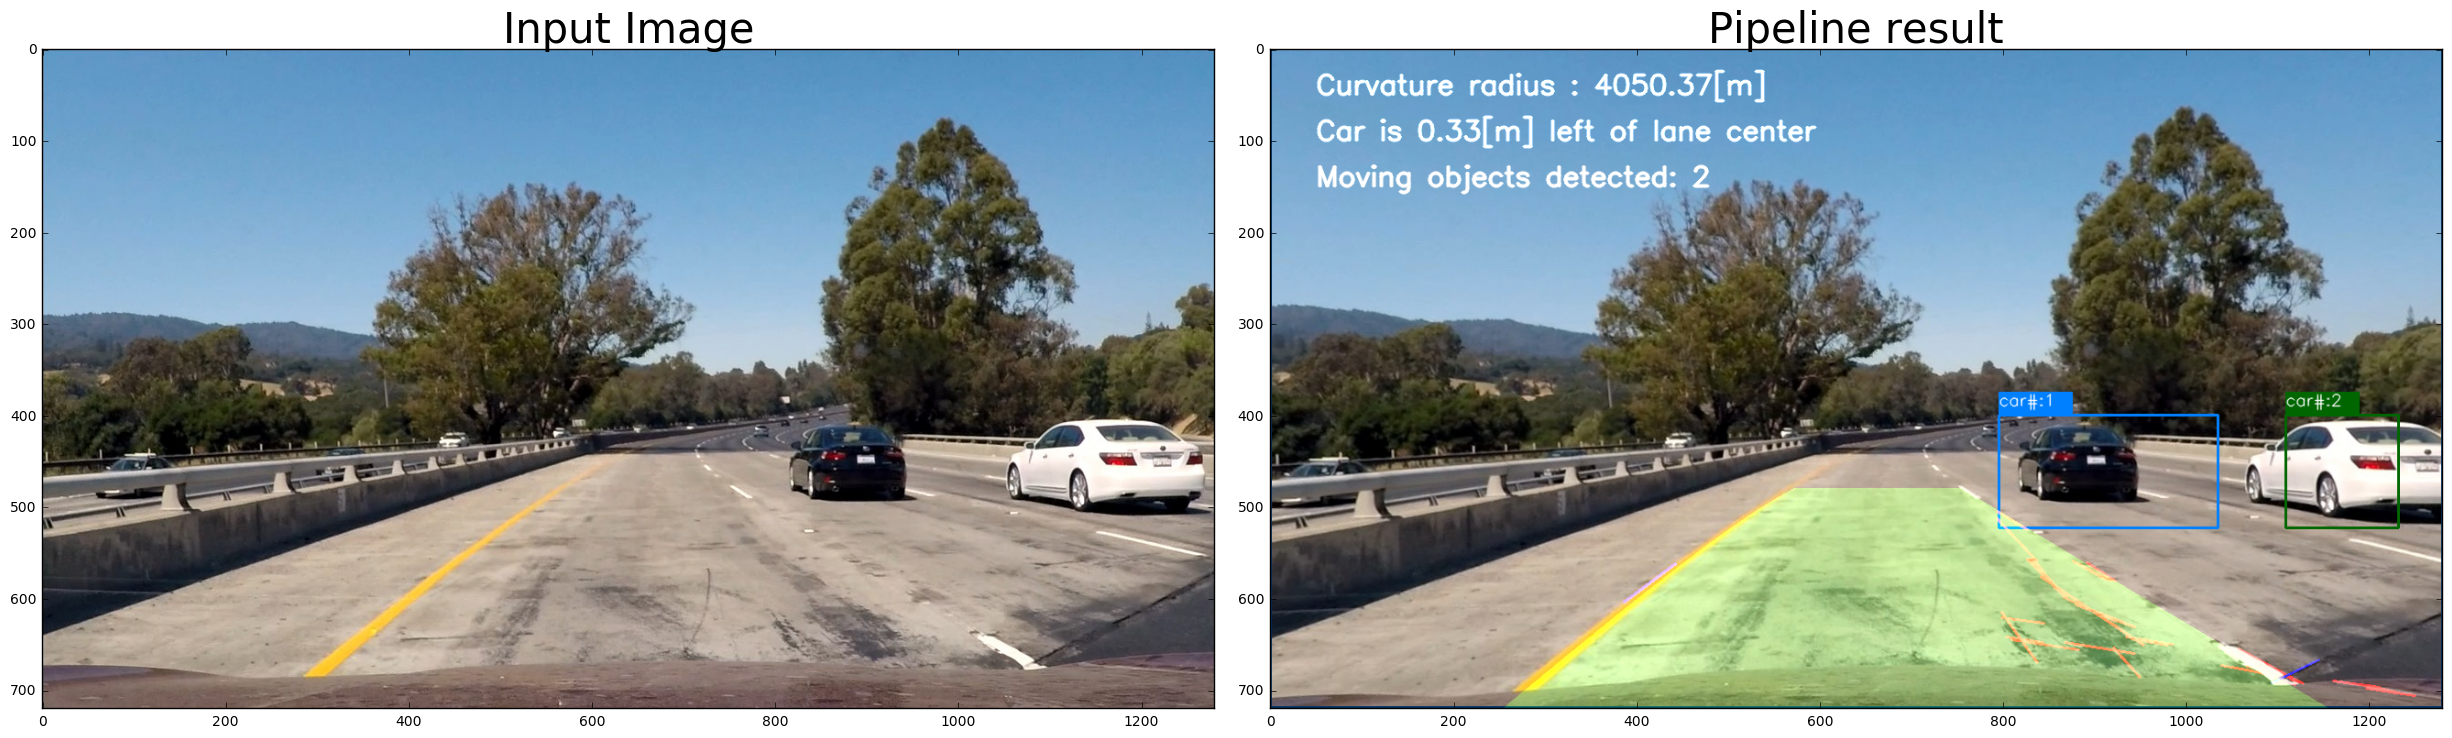

In [235]:
image = mpimg.imread('test_images/test1.jpg')
global_heatmap.debug_flag = False
global_heatmap.t0_flag=True 
Right_line.very_first = True
Right_line.detected = Left_line.detected = False
output_image = image_pipeline(image)
plot_compare(image,output_image,'Input Image','Pipeline result')

### Processing all example images

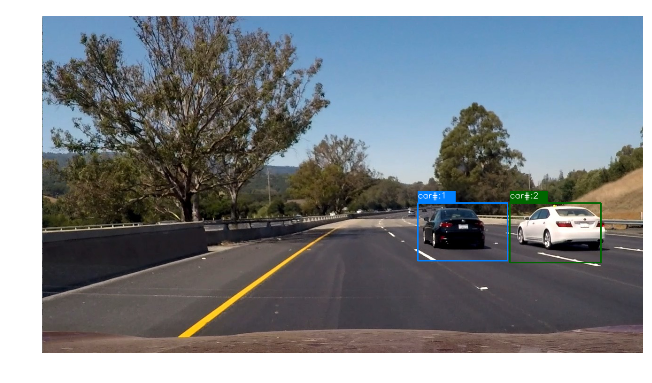

In [481]:

images_array=glob.glob('test_images/*.jpg')
os.listdir("test_images/")
for image_name in images_array :
    #reading in an image
    image = mpimg.imread(image_name)
    global_heatmap.t0_flag=True 
    global_heatmap.debug_flag = False  # debug=True added heatmap to output
    output_image = image_pipeline(image)
    plt.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)  
    plt.imshow(output_image)
    plt.savefig(os.path.splitext(image_name)[0]+'_result.jpg') # Saving image to file

In [31]:

def pipe_wrap (image):
 
    output_image = image_pipeline(image)
          
    return output_image

In [243]:
global_heatmap.t0_flag=True 
global_heatmap.debug_flag = True  # debug=True added heatmap to output
Right_line.very_first = True
Right_line.detected = Left_line.detected = False
white_output = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipe_wrap) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [3:51:29<00:11, 11.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 

Wall time: 3h 51min 31s


In [244]:
HTML("""
<video width="576" height="324" controls>
  <source src="{0}">
</video>
""".format(white_output))